# Setup

In [1]:
# Standard library
import os
import math
import warnings

# Core scientific libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches

# Scikit-learn: preprocessing, modeling, evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.exceptions import ConvergenceWarning

# Settings and warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
pd.options.display.max_columns = None

# set working directory
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
# Load Data
no_spills = gpd.read_file('no_spills_cleaned.geojson')
spills = gpd.read_file('spills_cleaned.geojson')
print("No Spills Shape:", no_spills.shape)
print("Spills Shape:", spills.shape)

# Combine both datasets
complete_data = pd.concat([no_spills, spills], ignore_index=True)
print("Combined Data Shape:", complete_data.shape)

No Spills Shape: (3866, 15)
Spills Shape: (57, 15)
Combined Data Shape: (3923, 15)


# Exploratory Data Analysis

## Spatial Distribution

In [5]:
def spatial_risk_map(
    gdf,
    risk_col='risk',
    title=None,
    test_index=None,
    preds_dict=None,
    zoom_bounds=None,
    stacked=False
):
    """
    General-purpose risk map plotting function using contextily.

    Parameters:
    - gdf: GeoDataFrame (projected or unprojected)
    - risk_col: Name of the risk column to plot (default: 'risk')
    - title: Optional title for single map
    - test_index: Optional index to subset the gdf
    - preds_dict: Optional dictionary of predictions to plot (for comparison plots)
                  Format: {plot_title: prediction_series}
    - zoom_bounds: Tuple (x_min, x_max, y_min, y_max) to zoom to a region
    - stacked: If True and preds_dict is provided, plots maps stacked vertically
    """

    # Filter to test index if provided
    if test_index is not None:
        gdf = gdf.loc[test_index].copy()
    else:
        gdf = gdf.copy()

    # Convert CRS for basemap
    gdf = gdf.to_crs(epsg=3857)

    # Plot multiple maps (e.g., Regular, PCA, CCA)
    if preds_dict:
        fig, axes = plt.subplots(len(preds_dict), 1, figsize=(12, 6 * len(preds_dict)))

        if len(preds_dict) == 1:
            axes = [axes]  # force list if only one plot

        for ax, (sub_title, preds) in zip(axes, preds_dict.items()):
            temp_gdf = gdf.copy()
            temp_gdf[risk_col] = preds
            temp_gdf = temp_gdf.sort_values(by=risk_col)

            # Plot risk by color
            temp_gdf.plot(
                column=risk_col,
                ax=ax,
                cmap=ListedColormap(['blue', 'red']),
                norm=Normalize(vmin=0, vmax=1),
                alpha=0.7,
                linewidth=2
            )

            # Add basemap and clean axes
            ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
            ax.set_title(sub_title, fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])

        # Add shared legend
        plt.legend(
            handles=[
                mpatches.Patch(color='blue', label='Low Risk'),
                mpatches.Patch(color='red', label='High Risk')
            ],
            loc='lower center',
            bbox_to_anchor=(0.5, -0.05),
            ncol=2
        )
        plt.tight_layout()
        plt.show()
        return

    # Single risk map
    gdf = gdf.sort_values(by=risk_col)
    fig, ax = plt.subplots(figsize=(12, 12))

    gdf.plot(
        column=risk_col,
        ax=ax,
        cmap=ListedColormap(['blue', 'red']),
        norm=Normalize(vmin=0, vmax=1),
        alpha=0.7,
        linewidth=3
    )

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Add title if provided
    if title:
        ax.set_title(title, fontsize=16)

    # Clean axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Apply zoom if provided
    if zoom_bounds:
        x_min, x_max, y_min, y_max = zoom_bounds
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Add legend
    plt.legend(
        handles=[
            mpatches.Patch(color='red', label='Spill'),
            mpatches.Patch(color='blue', label='No Spill')
        ],
        loc='upper right'
    )

    plt.show()

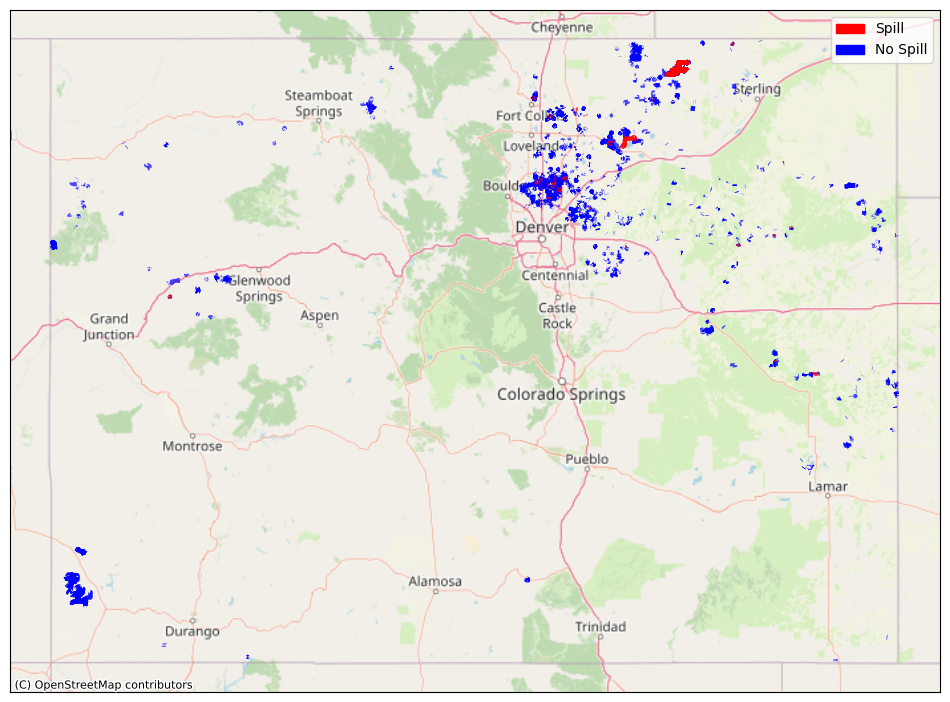

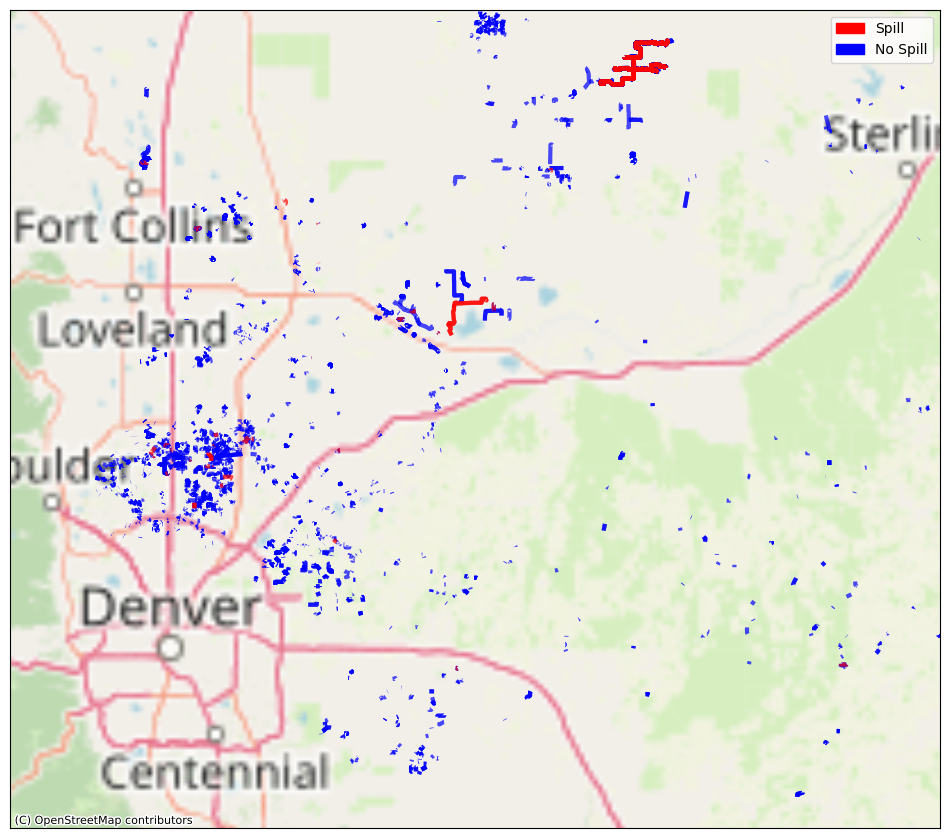

In [8]:
# Plot full risk map
spatial_risk_map(complete_data) #title="Flowline Risk in Colorado")

# Plot zoomed-in risk map (focus area)
spatial_risk_map(
    complete_data,
    # title="Zoomed-In Risk Map",
    zoom_bounds=(-11730000, -11480000, 4780000, 5000000)
)

## Risk Frequency Graphs

In [23]:
# Calculate total number of instances
total_instances = len(complete_data)

# Calculate frequencies of low and high risk
low_risk_frequency = (complete_data['risk'] == 0).sum() / total_instances
high_risk_frequency = (complete_data['risk'] == 1).sum() / total_instances
print(f"Low Risk:  {low_risk_frequency:.2%}")
print(f"High Risk: {high_risk_frequency:.2%}")

Low Risk:  98.55%
High Risk: 1.45%


In [24]:
def risk_vs_parameters(data, parameters, titles, xlabels, ylabel, n_cols=2):
    # Determine number of rows and columns for subplot grid
    n = len(parameters)
    n_rows = math.ceil(n / n_cols)

    # Create subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows), sharey=False)
    axes = axes.flatten()

    # Loop through each parameter to plot its risk distribution
    for i, (param, title, xlabel) in enumerate(zip(parameters, titles, xlabels)):
        ax = axes[i]

        # Keep only categories where risk=1 appears
        risk_1_data = data[data['risk'] == 1][param].unique()
        filtered_data = data[data[param].isin(risk_1_data)]

        # Count combinations of param and risk
        counts = filtered_data.groupby([param, 'risk']).size().reset_index(name='counts')

        # Pivot to get risk levels as columns
        pivot_counts = counts.pivot(index=param, columns='risk', values='counts').fillna(0)

        # Normalize to get proportions
        pivot_counts = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

        # Plot stacked bar chart (not actually stacked visually)
        pivot_counts.plot(kind='bar', stacked=False, ax=ax, legend=False)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', labelrotation=45)

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Shared legend for the figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, ['Low', 'High'], title='Risk',
        loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

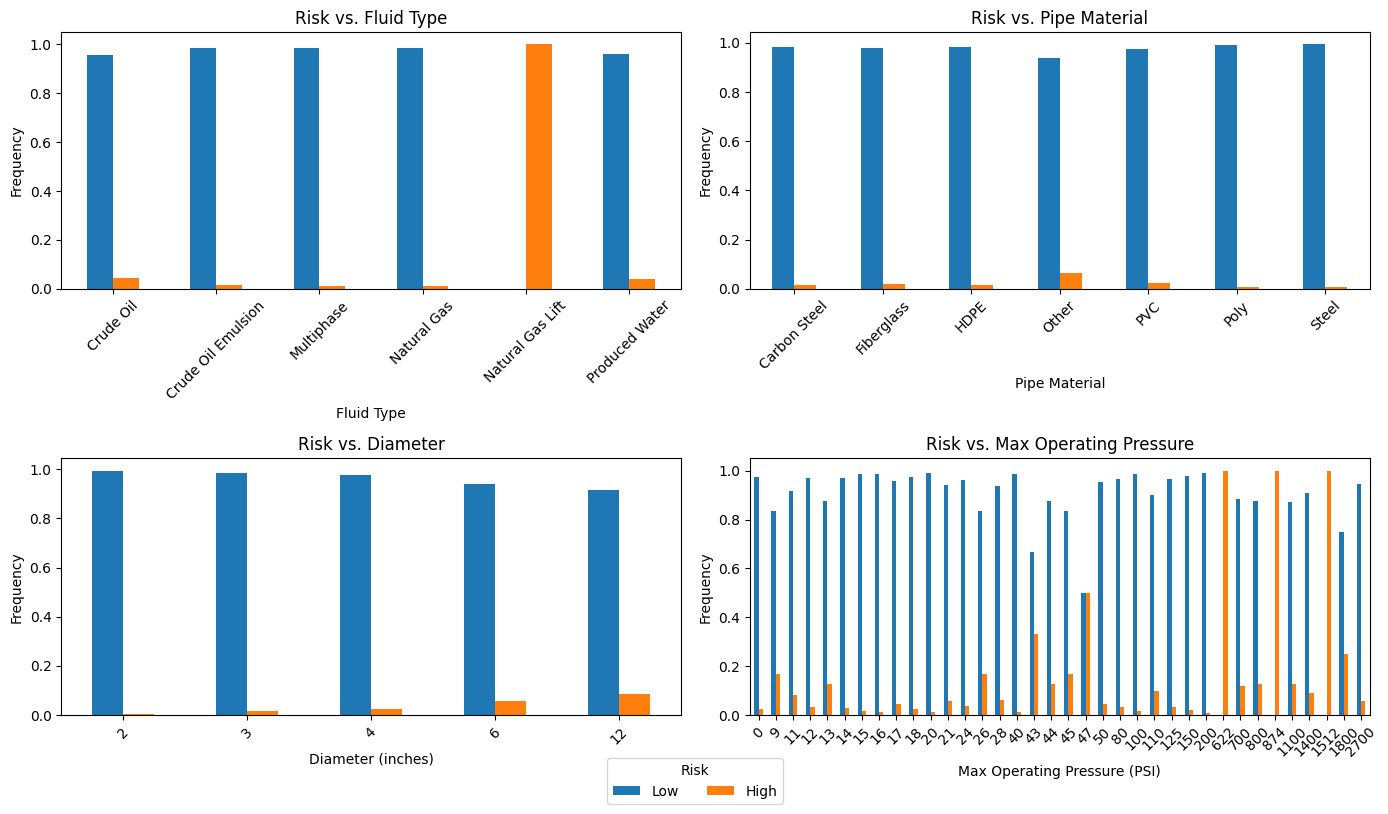

In [25]:
# Note: Status, Flowline Action, Location Type, Length, Number of Lines, Bounding Box Area are not imformative plots:  

risk_vs_parameters(
    complete_data,
    parameters=[
        'fluid',
        'material',
        'diameter_in',
        # 'operator_number',
        # 'line_age_yr',
        'max_operating_pressure'
    ],
    titles=[
        'Risk vs. Fluid Type',
        'Risk vs. Pipe Material',
        'Risk vs. Diameter',
       # 'Risk vs. Operator Number',
       # 'Risk vs. Line Age',
        'Risk vs. Max Operating Pressure'
    ],
    xlabels=[
        'Fluid Type',
        'Pipe Material',
        'Diameter (inches)',
       # 'Operator Number',
       # 'Line Age (years)',
        'Max Operating Pressure (PSI)'
    ],
    ylabel='Frequency'
)

In [26]:
# Count number of flowlines per operator
flowlines_per_operator = complete_data['operator_number'].value_counts()

# Summary statistics
total_operators = flowlines_per_operator.shape[0]
total_flowlines = flowlines_per_operator.sum()
mean_flowlines = flowlines_per_operator.mean()
median_flowlines = flowlines_per_operator.median()
max_flowlines = flowlines_per_operator.max()
min_flowlines = flowlines_per_operator.min()

# Percentage of flowlines owned by top N operators
top_n = 10
flowlines_top_n = flowlines_per_operator.head(top_n).sum()
percent_top_n = (flowlines_top_n / total_flowlines) * 100

# Display results
print(f"Total operators: {total_operators}")
print(f"Total flowlines: {total_flowlines}")
print(f"Mean flowlines per operator: {mean_flowlines:.2f}")
print(f"Median flowlines per operator: {median_flowlines}")
print(f"Min flowlines per operator: {min_flowlines}")
print(f"Max flowlines per operator: {max_flowlines}")
print(f"Top {top_n} operators own {flowlines_top_n} flowlines ({percent_top_n:.2f}% of total)")

unique_flowlines = complete_data['flowline_id'].nunique()
print(f"Number of unique flowline IDs: {unique_flowlines}")

Total operators: 83
Total flowlines: 3923
Mean flowlines per operator: 47.27
Median flowlines per operator: 7.0
Min flowlines per operator: 1
Max flowlines per operator: 837
Top 10 operators own 2841 flowlines (72.42% of total)
Number of unique flowline IDs: 3175


# Feature Engineering

## One hot encoding

Turning text columns into numbers

Ordinal Data: If the categories have a meaningful order or rank, they are ordinal. In such cases, assigning numbers like 1-5 makes sense as the numerical order reflects the order of the categories. For example, ratings from 'Very Poor' to 'Excellent' could be encoded as 1 through 5.

Nominal Data: If the categories do not have an inherent order, they are nominal. For such data, using numeric encoding (like 1, 2, 3, etc.) can inadvertently imply a hierarchy or order that doesn't actually exist, which might lead to misleading results in your model. Instead, you should use one-hot encoding (also known as dummy variables).

In [27]:
# Drop unnecessary identifier columns
# complete_data = complete_data.drop(columns=['operator_number', 'flowline_id', 'location_id', 'shape_length'])

# One-hot encode categorical variables (drop first to avoid multicollinearity)
complete_data_transformed = pd.get_dummies(
    complete_data,
    columns=['status', 'flowline_action', 'location_type', 'fluid', 'material'],
    drop_first=True
)

# Identify original columns from the untransformed dataset
original_columns = no_spills.columns.tolist()

# Get the new dummy columns created by one-hot encoding
new_dummy_columns = [col for col in complete_data_transformed.columns if col not in original_columns]

# Ensure dummy columns are integers (0 or 1)
complete_data_transformed[new_dummy_columns] = complete_data_transformed[new_dummy_columns].astype(int)

# Print summary info and shape of the transformed DataFrame
print(complete_data_transformed.shape)

(3923, 61)


### Geometery Feature Extraction

In [28]:
# Calculate number of line segments in each geometry
# MultiLineString: count its components; otherwise assign 1
complete_data_transformed['num_lines'] = complete_data_transformed['geometry'].apply(
    lambda x: len(x.geoms) if x.geom_type == 'MultiLineString' else 1
)

# Calculate area of each geometry’s bounding box (extent/footprint)
complete_data_transformed['bounds_area'] = complete_data_transformed['geometry'].bounds.apply(
    lambda x: (x['maxx'] - x['minx']) * (x['maxy'] - x['miny']),
    axis=1
)

# Extract only geometry column for spatial plotting later
geo = complete_data_transformed[['geometry']]

# Get test set indices (used for spatial comparisons)
_, test_indices = train_test_split(complete_data_transformed.index, test_size=0.3, random_state=42)
test_geometry = geo.loc[test_indices]

# Drop geometry from the modeling DataFrame (since ML models can't use geometry)
complete_data_transformed = complete_data_transformed.drop(columns=['geometry'])

In [29]:
# Print summary info and shape of the transformed DataFrame
print(complete_data_transformed.shape)

(3923, 62)


## Correlation Analysis

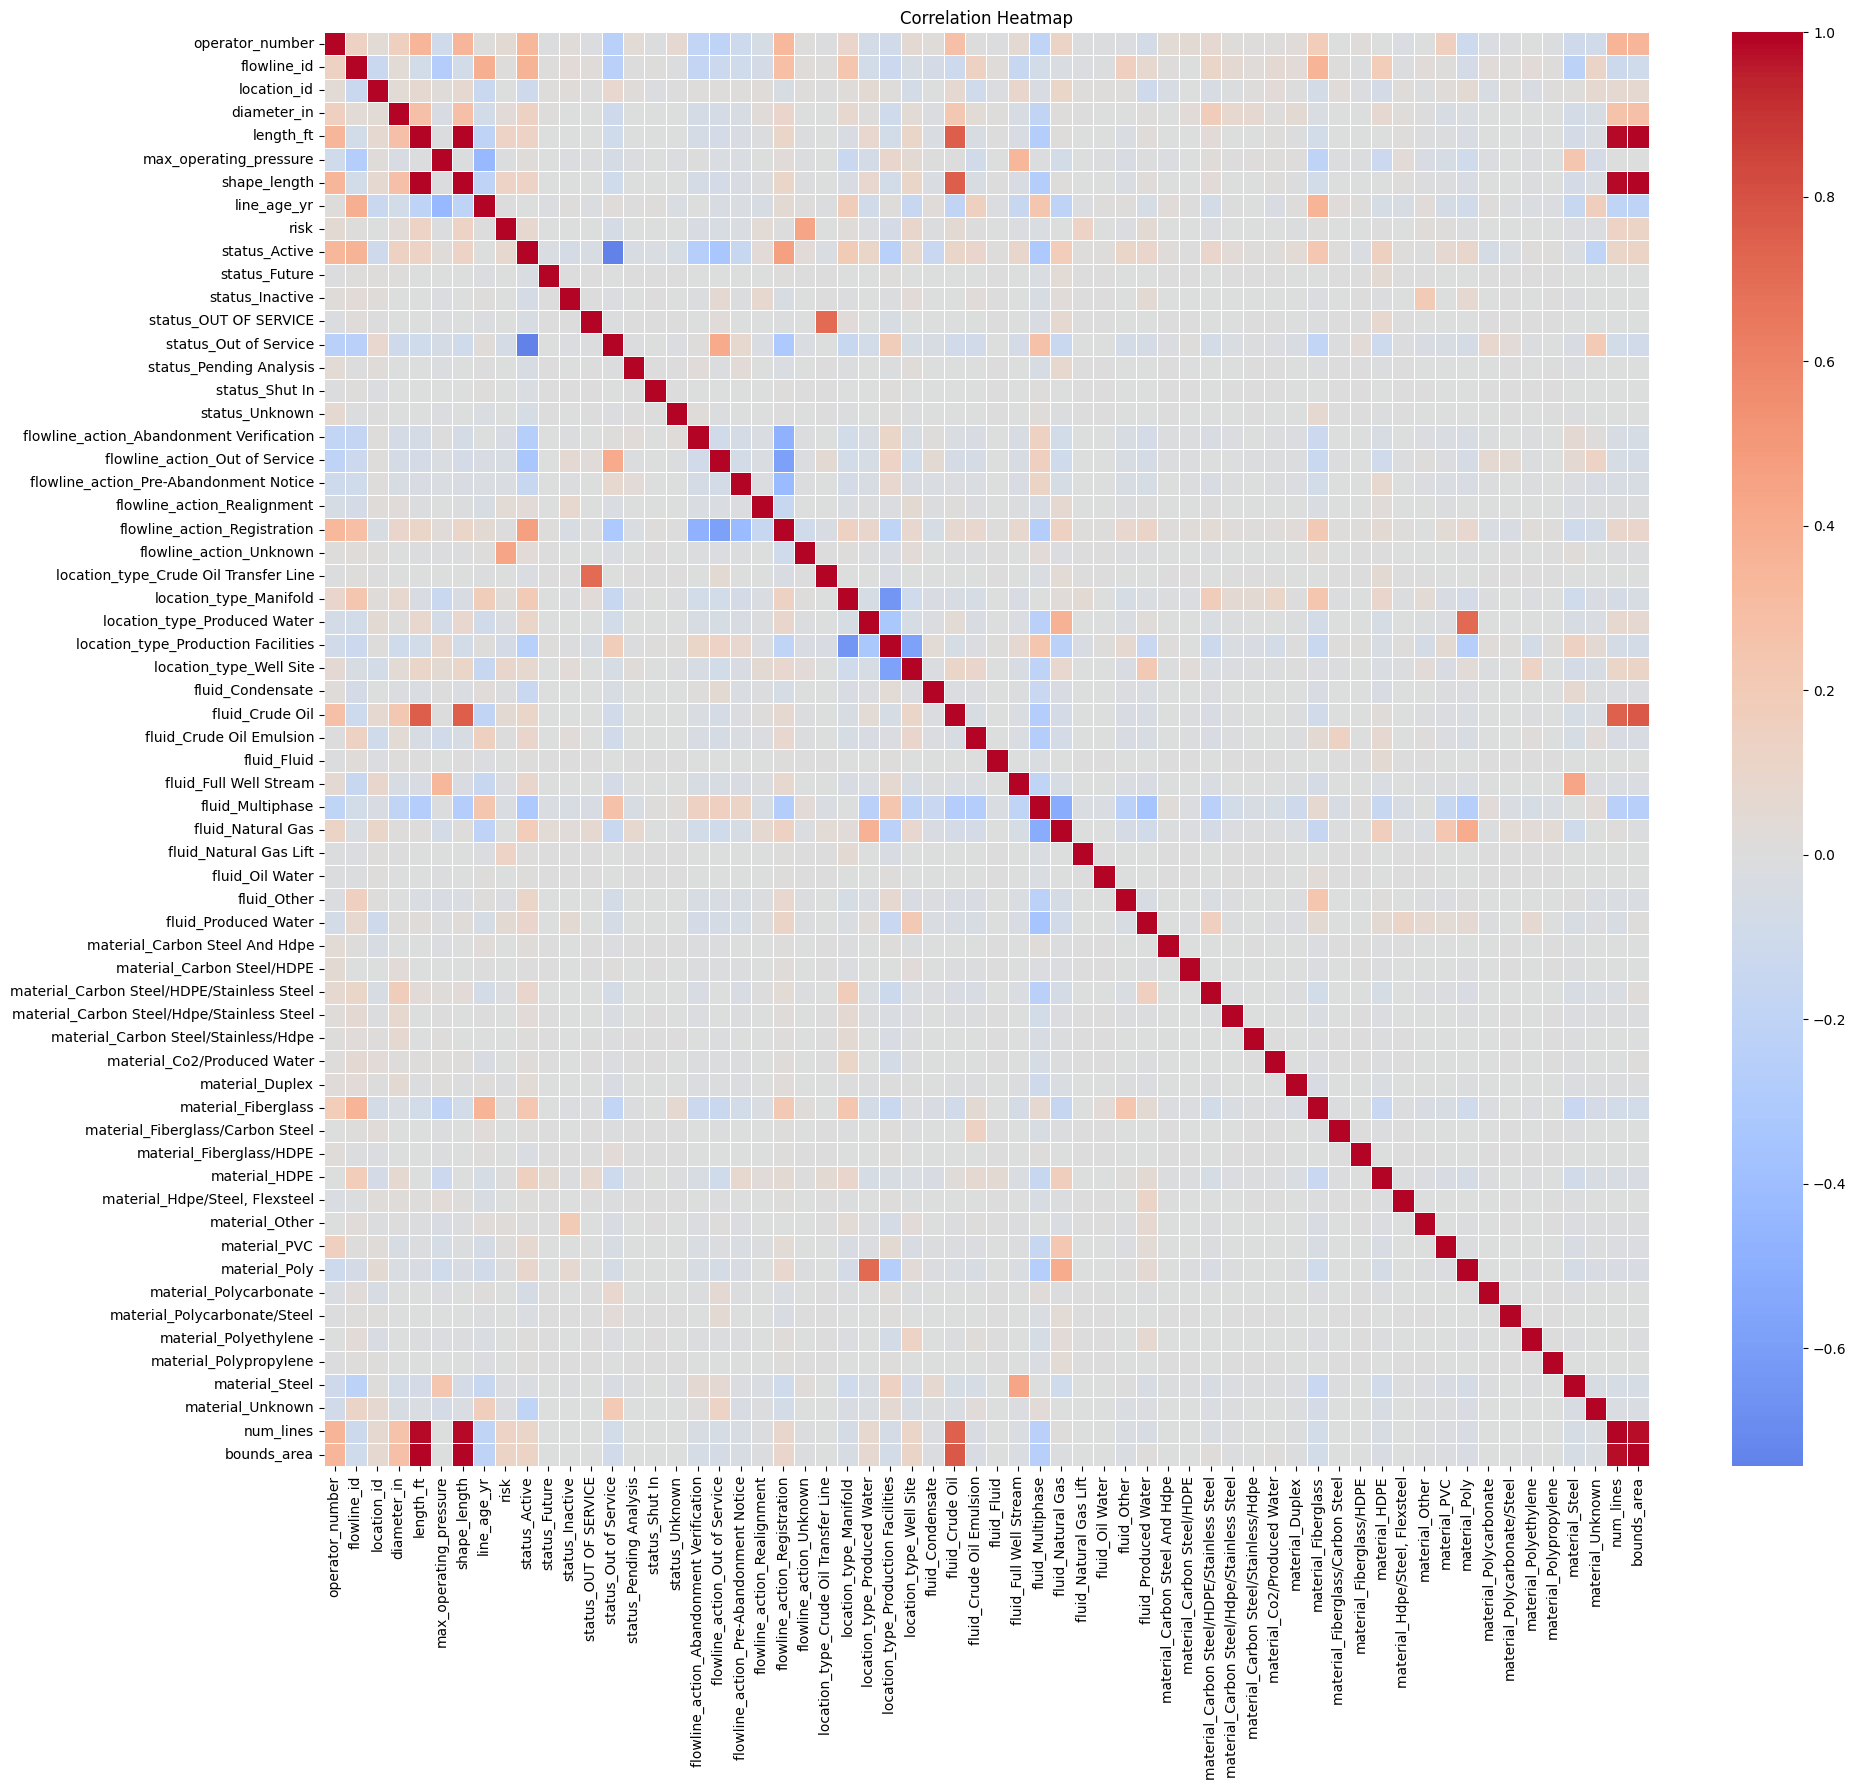

In [30]:
# Get list of feature names
feature_names = complete_data_transformed.columns

# Compute correlation matrix for all features
corr = complete_data_transformed[feature_names].corr()

# Plot full correlation heatmap
plt.figure(figsize=(20, 18))  # Increase figure size for visibility
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# Supervised ML Models

## Modeling Setup

In [31]:
# Prepare data
inputs = complete_data_transformed.drop(columns=['risk'])
outputs = complete_data_transformed['risk']

# Train test split, stratified by risk
trainX, testX, trainY, testY = train_test_split(
    inputs, outputs,
    test_size=0.3,
    random_state=42,
    stratify=outputs
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(trainX)
X_test_scaled = scaler.transform(testX) 

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Create empty DataFrame with test index to store best model predictions
comparison_preds = pd.DataFrame(index=testX.index)

In [32]:
def modeling_pipeline(modeling_type, classifiers, X_train, X_test, trainY, testY, test_index,
                    pca_n_components=2, cca_n_components=1, col_name='Regular', comparison_preds=None):
    """
    Evaluate a set of classifiers under different transformation schemes and update a predictions DataFrame.
    
    Parameters:
      - modeling_type (str): 'regular', 'pca', or 'cca'
      - classifiers (dict): dictionary mapping model name to classifier instance.
      - X_train, X_test: pre-scaled training and testing features
      - trainY, testY: target variables for training and testing
      - test_index: index to use for the predictions Series (from original test DataFrame)
      - pca_n_components (int): number of PCA components to retain (only for 'pca')
      - cca_n_components (int): number of CCA components to retain (only for 'cca')
      - col_name (str): column name to store best predictions in comparison_preds
      - comparison_preds (DataFrame): DataFrame to store best predictions; must have test_index as index.
    
    Returns:
      - best_model_name (str): Name of the classifier with the highest test F1 score.
      - best_f1_score (float): The corresponding F1 score.
      - best_preds (pd.Series): Predictions (indexed by test_index) from the best model.
    """
    best_model_name = None
    best_f1_score = -1
    best_preds = None

    # Determine transformation based on modeling type.
    if modeling_type == 'regular':
        # No transformation: use the scaled data as is.
        X_train_trans = X_train
        X_test_trans = X_test

    elif modeling_type == 'pca':
        pca = PCA(n_components=pca_n_components)
        X_train_trans = pca.fit_transform(X_train)
        X_test_trans = pca.transform(X_test)
        
    elif modeling_type == 'cca':
        cca = CCA(n_components=cca_n_components)
        # CCA requires the target to be 2D
        X_train_trans, _ = cca.fit_transform(X_train, trainY.values.reshape(-1, 1))
        X_test_trans, _ = cca.transform(X_test, testY.values.reshape(-1, 1))
    else:
        raise ValueError("Unknown modeling_type. Choose from 'regular', 'pca', or 'cca'.")

    # Loop over classifiers.
    for name, clf in classifiers.items():
        if modeling_type == 'regular':
            print(f"\n--- {name} ---")
        else:
            print(f"\n--- {name} with {modeling_type.upper()} ---")
            
        # Fit the classifier on the transformed training data.
        clf.fit(X_train_trans, trainY)
        y_train_pred = clf.predict(X_train_trans)
        y_test_pred = clf.predict(X_test_trans)

        # Compute metrics.
        acc_train = accuracy_score(trainY, y_train_pred)
        acc_test = accuracy_score(testY, y_test_pred)
        f1_train = f1_score(trainY, y_train_pred, pos_label=1)
        f1_test = f1_score(testY, y_test_pred, pos_label=1)

        # Print performance details.
        print(f"Train Accuracy: {acc_train:.4f} | Test Accuracy: {acc_test:.4f}")
        print(f"Train F1 Score: {f1_train:.4f} | Test F1 Score: {f1_test:.4f}")
        print("Confusion Matrix (Test):")
        print(confusion_matrix(testY, y_test_pred))
        print("Classification Report (Test):")
        print(classification_report(testY, y_test_pred, zero_division=0))

        # Update the best model based on test F1 score.
        if f1_test > best_f1_score:
            best_f1_score = f1_test
            best_model_name = name
            best_preds = pd.Series(y_test_pred, index=test_index)

    # Update the provided comparison_preds DataFrame if given.
    if comparison_preds is not None:
        comparison_preds[col_name] = best_preds

    # Print the best model and its F1 score.
    print(f"\n✅ Best {modeling_type.upper()} model based on F1 score: {best_model_name} ({best_f1_score:.4f})")
    
    return best_model_name, best_f1_score, best_preds

## Regular Models

### Results 

In [33]:
# Regular models evaluation:
best_reg_name, best_reg_f1, best_reg_preds = modeling_pipeline(
    modeling_type='regular',
    classifiers=classifiers,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    trainY=trainY,
    testY=testY,
    test_index=testX.index,
    col_name='Regular',
    comparison_preds=comparison_preds
)


--- Logistic Regression ---
Train Accuracy: 0.9894 | Test Accuracy: 0.9864
Train F1 Score: 0.4528 | Test F1 Score: 0.2000
Confusion Matrix (Test):
[[1159    1]
 [  15    2]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1160
           1       0.67      0.12      0.20        17

    accuracy                           0.99      1177
   macro avg       0.83      0.56      0.60      1177
weighted avg       0.98      0.99      0.98      1177


--- K-Nearest Neighbors ---
Train Accuracy: 0.9905 | Test Accuracy: 0.9847
Train F1 Score: 0.5806 | Test F1 Score: 0.3077
Confusion Matrix (Test):
[[1155    5]
 [  13    4]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1160
           1       0.44      0.24      0.31        17

    accuracy                           0.98      1177
   macro avg       0.72      0.62      0.65  

## Models with PCA

### Details

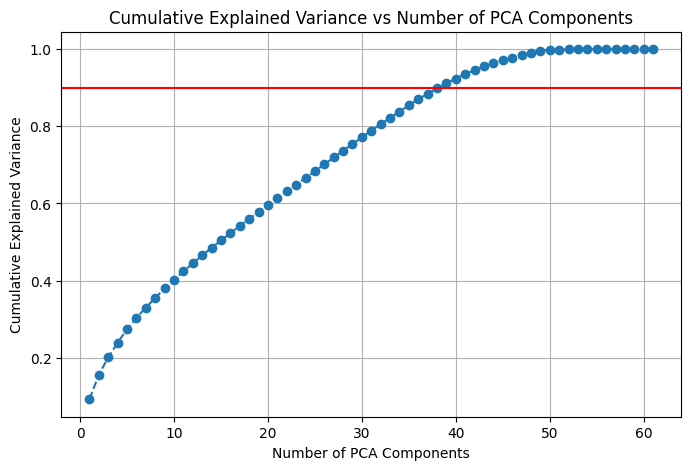

In [34]:
# Fit PCA on training data without limiting components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of PCA Components')
plt.grid()
plt.axhline(y=0.9, color='r', linestyle='-')  # Threshold line at 90%
plt.show()

In [43]:
# Fit PCA using 2 components
pca = PCA(n_components=2)
pca.fit(X_train_scaled)

# Use original feature names from training data
feature_names = trainX.columns

# Create DataFrame of PCA component loadings
pca_loadings = pd.DataFrame(pca.components_.T,
                            columns=["PC1", "PC2"],
                            index=feature_names)

# Add absolute values to rank features by contribution magnitude
pca_loadings["Abs_PC1"] = np.abs(pca_loadings["PC1"])
pca_loadings["Abs_PC2"] = np.abs(pca_loadings["PC2"])

# Display top contributing features to each principal component
print("\nTop 5 features contributing to PC1:")
print(pca_loadings.sort_values("Abs_PC1", ascending=False)[["PC1"]].head(5))

print("\nTop 5 features contributing to PC2:")
print(pca_loadings.sort_values("Abs_PC2", ascending=False)[["PC2"]].head(5))

# Show variance explained by each component
explained_variance = pca.explained_variance_ratio_
print("\nExplained variance by PC1 and PC2:", explained_variance)
print("Total variance explained:", explained_variance.sum())


Top 5 features contributing to PC1:
                      PC1
length_ft        0.402219
shape_length     0.402218
bounds_area      0.399592
num_lines        0.394111
fluid_Crude Oil  0.331521

Top 5 features contributing to PC2:
                                          PC2
status_Active                        0.349012
flowline_action_Registration         0.318941
flowline_id                          0.306397
status_Out of Service               -0.287988
location_type_Production Facilities -0.263420

Explained variance by PC1 and PC2: [0.09253203 0.06366072]
Total variance explained: 0.15619274858105187


### Results

In [36]:
# PCA models evaluation:
best_pca_name, best_pca_f1, best_pca_preds = modeling_pipeline(
    modeling_type='pca',
    classifiers=classifiers,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    trainY=trainY,
    testY=testY,
    test_index=testX.index,
    pca_n_components=2,
    col_name='PCA',
    comparison_preds=comparison_preds
)


--- Logistic Regression with PCA ---
Train Accuracy: 0.9854 | Test Accuracy: 0.9856
Train F1 Score: 0.0000 | Test F1 Score: 0.0000
Confusion Matrix (Test):
[[1160    0]
 [  17    0]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1160
           1       0.00      0.00      0.00        17

    accuracy                           0.99      1177
   macro avg       0.49      0.50      0.50      1177
weighted avg       0.97      0.99      0.98      1177


--- K-Nearest Neighbors with PCA ---
Train Accuracy: 0.9876 | Test Accuracy: 0.9864
Train F1 Score: 0.3462 | Test F1 Score: 0.2000
Confusion Matrix (Test):
[[1159    1]
 [  15    2]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1160
           1       0.67      0.12      0.20        17

    accuracy                           0.99      1177
   macro avg       0.83    

## Models with CCA

### Details

In [37]:
# One-hot encode the target labels for CCA (required format)
# encoder = OneHotEncoder(sparse_output=False)
# Y_train_encoded = encoder.fit_transform(trainY.values.reshape(-1, 1))

# Fit CCA with 2 components
cca = CCA(n_components=1)
cca.fit(X_train_scaled, trainY)

# Extract canonical weights for input features (similar to PCA loadings)
cca_weights = pd.DataFrame(
    cca.x_weights_,
    index=trainX.columns,
    columns=["Canonical 1"]
)

# Add absolute values to assess magnitude of contribution
cca_weights["Abs_C1"] = np.abs(cca_weights["Canonical 1"])

# Print top contributing features to each canonical component
print("\nTop 5 features contributing to Canonical 1:")
print(cca_weights.sort_values("Abs_C1", ascending=False)[["Canonical 1"]].head(5))


Top 5 features contributing to Canonical 1:
                         Canonical 1
length_ft                   0.707672
shape_length               -0.706540
flowline_action_Unknown     0.000658
bounds_area                -0.000646
fluid_Natural Gas Lift      0.000217


In [39]:
U = cca.x_scores_.ravel()  # canonical variate from X
V = cca.y_scores_.ravel()  # canonical variate from Y
r = np.corrcoef(U, V)[0, 1]
r2 = r**2
print("Canonical correlation:", r)
print("Shared variance (r^2):", r2)


AttributeError: 'CCA' object has no attribute 'x_scores_'

In [40]:
import numpy as np
import pandas as pd

# If Y is a 1D Series/array, make it 2D
Y_train_2d = np.asarray(trainY).reshape(-1, 1)

# Get canonical variates (scores)
Xc, Yc = cca.transform(X_train_scaled, Y_train_2d)  # shapes (n, 1), (n, 1)
U = Xc.ravel()
V = Yc.ravel()

# 1) Canonical correlation and shared variance
r = np.corrcoef(U, V)[0, 1]
r2 = r**2

# 2) Variance extracted (within each set), using correlations with the canonical score
def variance_extracted(X, s):
    # standardize X and s
    Xz = (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)
    sz = (s - s.mean()) / s.std(ddof=0)
    # correlations of each variable with the score
    load = (Xz * sz[:, None]).mean(axis=0)
    return np.mean(load**2)

var_X = variance_extracted(np.asarray(X_train_scaled), U)
var_Y = variance_extracted(Y_train_2d, V)  # for 1D Y, this is just corr(Y, V)^2

# 3) Redundancy: variance in one set explainable via the other through the canonical pair
redundancy_X_given_Y = var_X * r2
redundancy_Y_given_X = var_Y * r2

summary = pd.DataFrame({
    "canonical_r": [r],
    "canonical_r2": [r2],
    "var_extracted_X": [var_X],
    "var_extracted_Y": [var_Y],
    "redundancy_X|Y": [redundancy_X_given_Y],
    "redundancy_Y|X": [redundancy_Y_given_X],
})
print(summary.round(4))


   canonical_r  canonical_r2  var_extracted_X  var_extracted_Y  \
0       0.5442        0.2962              NaN              1.0   

   redundancy_X|Y  redundancy_Y|X  
0             NaN          0.2962  


/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_3047/2114520588.py:19: RuntimeWarning: invalid value encountered in divide
  Xz = (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)


### Results

In [41]:
# CCA models evaluation:
best_cca_name, best_cca_f1, best_cca_preds = modeling_pipeline(
    modeling_type='cca',
    classifiers=classifiers,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    trainY=trainY,
    testY=testY,
    test_index=testX.index,
    cca_n_components=1,
    col_name='CCA',
    comparison_preds=comparison_preds
)


--- Logistic Regression with CCA ---
Train Accuracy: 0.9854 | Test Accuracy: 0.9856
Train F1 Score: 0.0000 | Test F1 Score: 0.0000
Confusion Matrix (Test):
[[1160    0]
 [  17    0]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1160
           1       0.00      0.00      0.00        17

    accuracy                           0.99      1177
   macro avg       0.49      0.50      0.50      1177
weighted avg       0.97      0.99      0.98      1177


--- K-Nearest Neighbors with CCA ---
Train Accuracy: 0.9913 | Test Accuracy: 0.9822
Train F1 Score: 0.6471 | Test F1 Score: 0.2759
Confusion Matrix (Test):
[[1152    8]
 [  13    4]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1160
           1       0.33      0.24      0.28        17

    accuracy                           0.98      1177
   macro avg       0.66    

# Visual of results

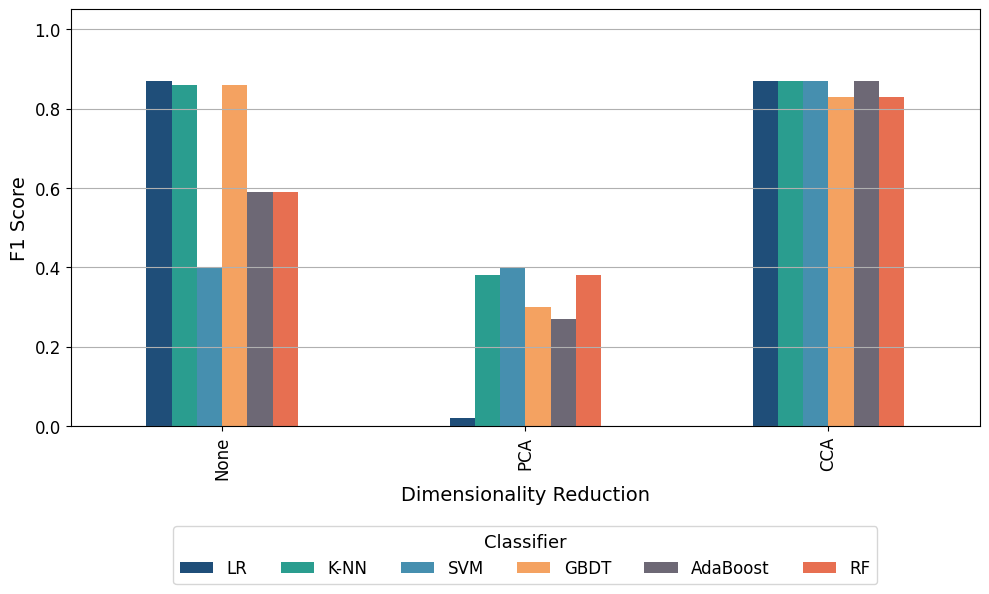

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Define F1 scores with small adjustment for PCA/LR
f1_data = {
    'None': {
        'LR': 0.87, 'K-NN': 0.86, 'SVM': 0.40,
        'GBDT': 0.86, 'AdaBoost': 0.59, 'RF': 0.59
    },
    'PCA': {
        'LR': 0.02, 'K-NN': 0.38, 'SVM': 0.40,
        'GBDT': 0.30, 'AdaBoost': 0.27, 'RF': 0.38
    },
    'CCA': {
        'LR': 0.87, 'K-NN': 0.87, 'SVM': 0.87,
        'GBDT': 0.83, 'AdaBoost': 0.87, 'RF': 0.83
    }
}

df_f1 = pd.DataFrame(f1_data).T

# Define poster-matching colors
colors = {
    'LR': '#1f4e79',
    'K-NN': '#2a9d8f',
    'SVM': '#468faf',
    'GBDT': '#f4a261',
    'AdaBoost': '#6d6875',
    'RF': '#e76f51'
}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
df_f1.plot(kind='bar', ax=ax, color=[colors[col] for col in df_f1.columns])

# Customize chart
ax.set_ylabel("F1 Score", fontsize=14)
ax.set_xlabel("Dimensionality Reduction", fontsize=14)
# ax.set_title("F1 Scores by Classifier and Reduction Method", fontsize=16, weight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, 1.05)
ax.grid(True, axis='y')

# Single-row legend across bottom
ax.legend(
    title="Classifier",
    fontsize=12,
    title_fontsize=13,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    ncol=6
)

# Layout spacing
fig.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.show()
